# Dark units (Marques, KS3)

TODO: fix SortingTrue_m's sorting accuracy attribute. It was calculated with all units without filtering the single units.

In [1]:
%load_ext autoreload
%autoreload 2
import os 
from matplotlib import pyplot as plt
import numpy as np
from collections import Counter
import pandas as pd
import seaborn as sns 
import spikeinterface as si
import copy
proj_path = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/spikebias/"
os.chdir(proj_path)

from src.nodes.postpro.cell_matching import get_SpikeInterface_matching_object, match_sorted_to_true_neuropixels_2023_02_19
from src.nodes.utils import get_config
from src.nodes.postpro.feateng import (add_firing_rates)
from src.nodes.postpro import spikestats
from src.nodes.study import bias
from src.nodes.metrics import spike

# set classification parameters
LOW_RATE_CEILING = 0.2  # max firing rate where negative proba change is observed in "bias plot" (sparse units)
DET_THRESH = 0.8
CHANCE_THRESH = 0.1

# spike waveform ms for snr
MS_BEFORE = 3
MS_AFTER = 3

# silico marques
data_conf, param_conf = get_config("silico_neuropixels", "2023_10_18").values()
SORTING_PATH_m = data_conf["sorting"]["sorters"]["kilosort3"]["output"]
GT_SORTING_PATH_m = data_conf["sorting"]["simulation"]["ground_truth"]["output"]
RECORDING_PATH_m = data_conf["probe_wiring"]["output"]
SORTING_PATH_m = data_conf["sorting"]["sorters"]["kilosort3"]["output"]
STUDY_FOLDER_m = data_conf["postprocessing"]["waveform"]["ground_truth"]["study"]

# FIGURE SETTINGS
COLOR_VIVO = (0.7, 0.7, 0.7)
COLOR_SILI = (0.84, 0.27, 0.2)
COLOR_STIM = (0.6, 0.75, 0.1)
BOX_ASPECT = 1                  # square fig
plt.rcParams['figure.figsize'] = (2,1)
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 6
plt.rcParams['lines.linewidth'] = 0.5
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.major.width'] = 0.3
plt.rcParams['xtick.minor.size'] = 0.1
plt.rcParams['xtick.major.size'] = 1.5
plt.rcParams['ytick.major.size'] = 1.5
plt.rcParams['ytick.major.width'] = 0.3
legend_cfg = {"frameon": False, "handletextpad": 0.1}
savefig_cfg = {"transparent":True}
# print(plt.rcParams.keys())

2024-02-25 12:20:09,331 - root - utils.py - get_config - INFO - Reading experiment config.
2024-02-25 12:20:09,354 - root - utils.py - get_config - INFO - Reading experiment config. - done


In [2]:
# takes 2 min

# get true/sorted matching object
MatchingObject_m = get_SpikeInterface_matching_object(GT_SORTING_PATH_m, SORTING_PATH_m)

In [3]:
agreem_mx_m = bias.format_agreement_matrix(MatchingObject_m)

In [4]:
# filter the sorted single units

# marques
Sorting_m = si.load_extractor(SORTING_PATH_m)
agreem_mx_m = agreem_mx_m.loc[
    Sorting_m.unit_ids[Sorting_m.get_property("KSLabel") == "good"], :
]

combination of biases: ['oversplit' 'poorly detected']


/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/spikebias/src/nodes/study/bias.py:247: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


Text(0.5, -33.40819350104296, 'Simulated recordings')

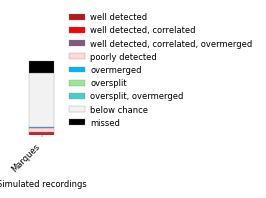

In [5]:
# takes 2 secs

# record agreement matrices for each dataset
agreem_mxs = [agreem_mx_m]
agreem_names = ["Marques"]

df = pd.DataFrame()

for ix, mx_i in enumerate(agreem_mxs):

    # classify sorting biases for this dataset
    bias_labels = bias.classify_true_unit_biases(mx_i, DET_THRESH, CHANCE_THRESH)

    # calculate proportions of biases for this dataset
    biases_ratio_df = bias.create_true_biases_df(bias_labels)
    df[agreem_names[ix]] = biases_ratio_df["cell_count"].values

df.index = biases_ratio_df.index

# plot
fig, axis = plt.subplots(1, 1, figsize=(0.5, 1))
axis = bias.plot_biases(axis, df)
axis.set_xlabel("Simulated recordings")

### Get all true units features

In [6]:
# takes 10 min

# get ground truth
SortingTrue_m = si.load_extractor(GT_SORTING_PATH_m)

# get signal-to-noise ratio
snrs = spike.get_true_units_SNRs(RECORDING_PATH_m, STUDY_FOLDER_m, MS_BEFORE, MS_AFTER)

# get firing rates
snrs = spike.get_true_units_SNRs(RECORDING_PATH_m, STUDY_FOLDER_m, MS_BEFORE, MS_AFTER)

# get spatial spread
spatial_spread = spike.get_spatial_spread_all_units(
    RECORDING_PATH_m, STUDY_FOLDER_m, MS_BEFORE, MS_AFTER
)

### Sort by missed and detected units

In [7]:
# takes 30 secs

# - get missed true units
# - get well detected true units
# - how do their features significantly differ?

# MISSED UNITS -----------

# get true distances
missed_true_units = bias_labels[bias_labels.values == "missed"].index.tolist()
distances_missed = spike.get_distance_for(
    missed_true_units, SortingTrue_m, RECORDING_PATH_m
)

# get snrs
snrs_missed = [snrs[ix] for ix in missed_true_units]

# get firing rates
firing_rates_missed = spike.get_firing_rates_for(missed_true_units, SortingTrue_m)

# get spatial spread
spread_missed = [spatial_spread[ix] for ix in missed_true_units]

# get layer
layers_missed = spike.get_layer_for(missed_true_units, SortingTrue_m)

# get synapse class
synapse_class_missed = spike.get_synapse_class_for(missed_true_units, SortingTrue_m)

# get synapse class
etype_missed = spike.get_etype_for(missed_true_units, SortingTrue_m)

# get synapse class
mtype_missed = spike.get_mtype_for(missed_true_units, SortingTrue_m)

# WELL DETECTED UNITS -----------

# get true distances
detected_true_units = bias_labels[bias_labels.values == "well detected"].index.tolist()
distances_detected = spike.get_distance_for(
    detected_true_units, SortingTrue_m, RECORDING_PATH_m
)
# get snrs
snrs_detected = [snrs[ix] for ix in detected_true_units]

# get firing rates
firing_rates_detected = spike.get_firing_rates_for(detected_true_units, SortingTrue_m)

# get spatial spread
spread_detected = [spatial_spread[ix] for ix in detected_true_units]

# get layer
layers_detected = spike.get_layer_for(detected_true_units, SortingTrue_m)

# get synapse class
synapse_class_detected = spike.get_synapse_class_for(detected_true_units, SortingTrue_m)

# get etype
etype_detected = spike.get_etype_for(detected_true_units, SortingTrue_m)

# get mtype
mtype_detected = spike.get_mtype_for(detected_true_units, SortingTrue_m)


# CREATE FEATURE DATASET

# missed unit features
missed_data = pd.DataFrame()
missed_data["distance"] = distances_missed
missed_data["snr"] = snrs_missed
missed_data["firing rate"] = firing_rates_missed
missed_data["spread"] = spread_missed
missed_data["layer"] = layers_missed
missed_data["synapse class"] = synapse_class_missed
missed_data["etype"] = etype_missed
missed_data["mtype"] = mtype_missed
missed_data["bias"] = "Missed"

# detected unit features
detected_data = pd.DataFrame()
detected_data["distance"] = distances_detected
detected_data["snr"] = snrs_detected
detected_data["firing rate"] = firing_rates_detected
detected_data["spread"] = spread_detected
detected_data["layer"] = layers_detected
detected_data["synapse class"] = synapse_class_detected
detected_data["etype"] = etype_detected
detected_data["mtype"] = mtype_detected
detected_data["bias"] = "Detected"

# concat for plot
plot_data = pd.concat([missed_data, detected_data], ignore_index=True)

### Plot quantitative features

,distance,snr,firing rate,spread,layer,synapse class,etype,mtype,bias
0,11.426037,12.147282,0.003401,433.458738,6,EXC,cADpyr,L6_BPC,Missed
1,33.387475,4.458860,0.008503,300.251298,2,EXC,cADpyr,L2_TPC:B,Missed
2,12.050085,12.608667,0.005102,743.127335,6,EXC,cADpyr,L6_BPC,Missed
3,5.339407,28.421812,0.006803,534.134566,3,EXC,cADpyr,L3_TPC:C,Missed
4,8.266111,9.085604,0.008503,1386.073124,1,INH,cACint,L1_NGC-DA,Missed
...,...,...,...,...,...,...,...,...,...
240,26.052684,1.778297,1.693878,252.716463,6,INH,cNAC,L6_NBC,Detected
241,28.671510,2.746767,1.926872,479.095856,6,EXC,cADpyr,L6_TPC:A,Detected
242,9.889581,11.653646,0.877551,634.076780,4,EXC,cADpyr,L4_UPC,Detected
243,5.956232,27.550940,1.384354,490.034546,5,EXC,cADpyr,L5_TPC:C,Detected


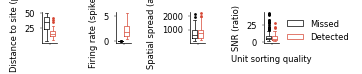

In [8]:
# FORMAT PLOT DATASET
ASPECT_RATIO = 2
GAP = 0.2
MARKERSIZE = 2

display(plot_data)

# PLOT
# fig, axes = plt.subplots(1, 4, figsize=(3.5, 0.7))
fig, axes = plt.subplots(1, 4, figsize=(3.5, 0.4))

# DISTANCE

ax = sns.boxplot(
    ax=axes[0],
    data=plot_data,
    hue="bias",
    y="distance",
    fill=False,
    palette=["k", COLOR_SILI],
    gap=GAP,
    linewidth=plt.rcParams["lines.linewidth"],
    flierprops={"marker": ".", "markersize": MARKERSIZE},
)
ax.spines[["top", "right"]].set_visible(False)
ax.legend("", frameon=False)
ax.set_ylabel("Distance to site (\u03bcm)")
ax.set_box_aspect(ASPECT_RATIO)

# FIRING RATE

ax = sns.boxplot(
    ax=axes[1],
    data=plot_data,
    hue="bias",
    y="firing rate",
    fill=False,
    palette=["k", COLOR_SILI],
    gap=GAP,
    linewidth=plt.rcParams["lines.linewidth"],
    flierprops={"marker": ".", "markersize": MARKERSIZE},
)

ax.spines[["top", "right"]].set_visible(False)
ax.legend("", frameon=False)
ax.set_ylabel("Firing rate (spike/s)")
ax.set_box_aspect(ASPECT_RATIO)
fig.subplots_adjust(wspace=0.5, hspace=0.1)

# SPREAD

ax = sns.boxplot(
    ax=axes[2],
    data=plot_data,
    hue="bias",
    y="spread",
    fill=False,
    palette=["k", COLOR_SILI],
    gap=GAP,
    linewidth=plt.rcParams["lines.linewidth"],
    flierprops={"marker": ".", "markersize": MARKERSIZE},
)

ax.spines[["top", "right"]].set_visible(False)
ax.legend("", frameon=False)
ax.set_ylabel("Spatial spread (a.u)")
ax.set_box_aspect(ASPECT_RATIO)
fig.subplots_adjust(wspace=0.5, hspace=0.1)

# SNRS

ax = sns.boxplot(
    ax=axes[3],
    data=plot_data,
    hue="bias",
    y="snr",
    fill=False,
    palette=["k", COLOR_SILI],
    gap=GAP,
    linewidth=plt.rcParams["lines.linewidth"],
    flierprops={"marker": ".", "markersize": MARKERSIZE},
)
ax.set_box_aspect(ASPECT_RATIO)

ax.spines[["top", "right"]].set_visible(False)
ax.legend(frameon=False, loc="upper left", bbox_to_anchor=(1, 1))
ax.set_ylabel("SNR (ratio)")
ax.set_xlabel("Unit sorting quality")
# fig.subplots_adjust(wspace=0.5, hspace=0.1)

# save figures
plt.savefig(
    "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/spikebias/figures/3_bias/svg/quantitative_portrait_dark_units_marques_ks3.svg",
    **savefig_cfg,
)

In [12]:
print(plot_data["firing rate"][plot_data["bias"] == "Missed"].mean())
print(plot_data["firing rate"][plot_data["bias"] == "Detected"].mean())

0.004630084060038658
2.0822006088325105


### Plot qualitative features

In [380]:
colors = [
    [0.5, 0.5, 0.5],  # dark units
    [1, 0.85, 0.85],  # "poor" (pink)
    [0.7, 0.1, 0.1],  # "well detected" (strong red)
]

# get layers
layers_all = spike.get_layer_for(SortingTrue_m.unit_ids, SortingTrue_m)

# get synapse class
synclass_all = spike.get_synapse_class_for(SortingTrue_m.unit_ids, SortingTrue_m)

# get etype
etype_all = spike.get_etype_for(SortingTrue_m.unit_ids, SortingTrue_m)

# get mtype
mtype_all = spike.get_mtype_for(SortingTrue_m.unit_ids, SortingTrue_m)

# layers
l_df = pd.DataFrame(layers_all)
l_df.index = SortingTrue_m.unit_ids
l_df.columns = ["layer"]

# synapse class
s_df = pd.DataFrame(synclass_all)
s_df.index = SortingTrue_m.unit_ids
s_df.columns = ["synapse class"]

# etype
e_df = pd.DataFrame(etype_all)
e_df.index = SortingTrue_m.unit_ids
e_df.columns = ["etype"]

# mtype
m_df = pd.DataFrame(mtype_all)
m_df.index = SortingTrue_m.unit_ids
m_df.columns = ["mtype"]

# accuracy
accuracy_df = agreem_mx_m.max().to_frame()
accuracy_df.columns = ["accuracy"]

df = pd.DataFrame()
df["bias"] = bias_labels
df = df.merge(l_df, right_index=True, left_index=True)
df = df.merge(s_df, right_index=True, left_index=True)
df = df.merge(e_df, right_index=True, left_index=True)
df = df.merge(m_df, right_index=True, left_index=True)
df = df.merge(accuracy_df, right_index=True, left_index=True)

# classify into three levels of sorting quality
df["quality"] = len(df) * [np.nan]
df["quality"][df["accuracy"] == 0] = "dark units"
df["quality"][(df["accuracy"] <= 0.1) & (df["accuracy"] > 0)] = "dark units"
df["quality"][(df["accuracy"] > CHANCE_THRESH) & (df["accuracy"] < DET_THRESH)] = "poor"
df["quality"][df["accuracy"] >= DET_THRESH] = "well detected"

/tmp/ipykernel_113285/2360770895.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["quality"][df["accuracy"] == 0] = "dark units"


#### Layer

/tmp/ipykernel_113285/3789931544.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data["layer"][plot_data["layer"] == "2"] = "2/3"
/tmp/ipykernel_113285/3789931544.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data["layer"][plot_data["layer"] == "3"] = "2/3"
/tmp/ipykernel_113285/3789931544.py:42: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  ax.legend(


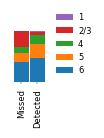

In [9]:
# combine layer 2/3
plot_data["layer"][plot_data["layer"] == "2"] = "2/3"
plot_data["layer"][plot_data["layer"] == "3"] = "2/3"

# format dataset to plot
df = plot_data["layer"][plot_data["bias"] == "Missed"]
df_ratio_missed = df.value_counts(normalize=True)
df_ratio_missed = df_ratio_missed.to_frame()
df_ratio_missed.columns = ["Missed"]

df = plot_data["layer"][plot_data["bias"] == "Detected"]
df_ratio_detected = df.value_counts(normalize=True)
df_ratio_detected = df_ratio_detected.to_frame()
df_ratio_detected.columns = ["Detected"]

# concat for plot
plot_data2 = pd.concat([df_ratio_missed, df_ratio_detected], axis=1)

# reorder layers
plot_data2 = plot_data2.loc[["6", "5", "4", "2/3", "1"]]

fig, axis = plt.subplots(1, 1, figsize=(0.5, 0.7))
ax = (plot_data2).T.plot.bar(
    ax=axis,
    stacked=True,
    # color=colors,
    width=0.9,
    edgecolor="none",
    linewidth=0.2,
)

# set axis legend
ax.spines[["left", "right", "top", "bottom"]].set_visible(False)
y_axis = ax.axes.get_yaxis()
y_axis.set_visible(False)
ax.set_ylabel("Sorting biases (ratio)", fontsize=9)

hs, ls = ax.get_legend_handles_labels()
hss = [hs[4], hs[3], hs[2], hs[1], hs[0]]
lss = [ls[4], ls[3], ls[2], ls[1], ls[0]]

ax.legend(
    plot_data2.index,
    ncol=1,
    loc="lower left",
    bbox_to_anchor=(1, 0),
    frameon=False,
    handletextpad=0.6,
    handles=hss,
    labels=lss,
)

# save figures
plt.savefig(
    "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/spikebias/figures/3_bias/svg/portrait_layer_dark_units_ks3.svg",
    **savefig_cfg,
)

#### plot 2

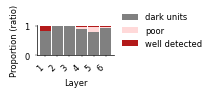

In [383]:
# ratio of sorting quality by layer
ctab = pd.crosstab(df["layer"], df["quality"])
sum_ctab = pd.crosstab(df["layer"], df["quality"]).sum(axis=1)
ctab_ratio = ctab.apply(lambda x: x / sum_ctab)

# plot
fig, ax = plt.subplots(1, figsize=(1, 0.4))
ax = ctab_ratio.plot.bar(ax=ax, stacked=True, color=colors, width=0.9)

# add legend
ax.set_xticklabels(ctab_ratio.index, rotation=45, ha="right")
ax.set_ylabel("Proportion (ratio)")
ax.set_xlabel("Layer")
ax.legend(frameon=False, loc="lower left", bbox_to_anchor=(1, 0))


# save figures
plt.savefig(
    "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/spikebias/figures/3_bias/svg/portrait_layer_dark_units_marques_ks3_plot2.svg",
    **savefig_cfg,
)

#### Synapse class (inh/exc)

#### plot 1

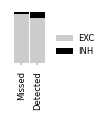

In [364]:
colors = ((0.8, 0.8, 0.8), (0, 0, 0))

# format dataset to plot
df = plot_data["synapse class"][plot_data["bias"] == "Missed"]
df_ratio_missed = df.value_counts(normalize=True)
df_ratio_missed = df_ratio_missed.to_frame()
df_ratio_missed.columns = ["Missed"]

df = plot_data["synapse class"][plot_data["bias"] == "Detected"]
df_ratio_detected = df.value_counts(normalize=True)
df_ratio_detected = df_ratio_detected.to_frame()
df_ratio_detected.columns = ["Detected"]

# concat for plot
plot_data3 = pd.concat([df_ratio_missed, df_ratio_detected], axis=1)

fig, axis = plt.subplots(1, 1, figsize=(0.5, 0.7))
ax = (plot_data3).T.plot.bar(
    ax=axis,
    stacked=True,
    color=colors,
    width=0.9,
    edgecolor="none",
)

# set axis legend
ax.spines[["left", "right", "top", "bottom"]].set_visible(False)
y_axis = ax.axes.get_yaxis()
y_axis.set_visible(False)
ax.set_ylabel("Sorting biases (ratio)", fontsize=9)
ax.legend(
    plot_data3.index,
    ncol=1,
    loc="lower left",
    bbox_to_anchor=(1, 0),
    frameon=False,
    handletextpad=0.6,
)

# save figures
plt.savefig(
    "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/spikebias/figures/3_bias/svg/portrait_synapse_dark_units_ks3.svg",
    **savefig_cfg,
)

#### plot 2

/tmp/ipykernel_113285/3937812528.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["quality"][df["accuracy"] == 0] = "dark units"


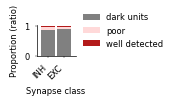

In [378]:
# ratio of sorting quality by etype
ctab = pd.crosstab(df["synapse class"], df["quality"])
sum_ctab = pd.crosstab(df["synapse class"], df["quality"]).sum(axis=1)
ctab_ratio = ctab.apply(lambda x: x / sum_ctab)
ctab_ratio = ctab_ratio.sort_values(by=["well detected"], ascending=False)

# plot
fig, ax = plt.subplots(1, figsize=(0.5, 0.4))
ax = ctab_ratio.plot.bar(ax=ax, stacked=True, color=colors, width=0.9)

# add legend
ax.set_xticklabels(ctab_ratio.index, rotation=45, ha="right")
ax.set_ylabel("Proportion (ratio)")
ax.set_xlabel("Synapse class")
ax.legend(frameon=False, loc="lower left", bbox_to_anchor=(1, 0))


# save figures
plt.savefig(
    "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/spikebias/figures/3_bias/svg/portrait_synclass_dark_units_marques_ks3_plot2.svg",
    **savefig_cfg,
)

### etype


#### Plot 1

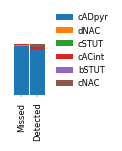

In [11]:
# format dataset to plot
df = plot_data["etype"][plot_data["bias"] == "Missed"]
df_ratio_missed = df.value_counts(normalize=True)
df_ratio_missed = df_ratio_missed.to_frame()
df_ratio_missed.columns = ["Missed"]

df = plot_data["etype"][plot_data["bias"] == "Detected"]
df_ratio_detected = df.value_counts(normalize=True)
df_ratio_detected = df_ratio_detected.to_frame()
df_ratio_detected.columns = ["Detected"]

# concat for plot
plot_data3 = pd.concat([df_ratio_missed, df_ratio_detected], axis=1)

# reorder etype
# plot_data3 = plot_data3.loc[["6", "5", "4", "2/3", "1"]]

fig, axis = plt.subplots(1, 1, figsize=(0.5, 0.7))
ax = (plot_data3).T.plot.bar(
    ax=axis,
    stacked=True,
    # color=colors,
    width=0.9,
    edgecolor="none",
    linewidth=0.2,
)

# set axis legend
ax.spines[["left", "right", "top", "bottom"]].set_visible(False)
y_axis = ax.axes.get_yaxis()
y_axis.set_visible(False)
ax.set_ylabel("Sorting biases (ratio)", fontsize=9)

# hs, ls = ax.get_legend_handles_labels()
# hss = [hs[4], hs[3], hs[2], hs[1], hs[0]]
# lss = [ls[4], ls[3], ls[2], ls[1], ls[0]]

ax.legend(
    plot_data3.index,
    ncol=1,
    loc="lower left",
    bbox_to_anchor=(1, 0),
    frameon=False,
    handletextpad=0.6,
    # handles=hss,
    # labels=lss,
)

# save figures
plt.savefig(
    "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/spikebias/figures/3_bias/svg/portrait_etype_dark_units_ks3.svg",
    **savefig_cfg,
)

#### plot 2

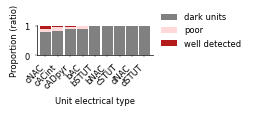

In [367]:
# ratio of sorting quality by etype
ctab = pd.crosstab(df["etype"], df["quality"])
sum_ctab = pd.crosstab(df["etype"], df["quality"]).sum(axis=1)
ctab_ratio = ctab.apply(lambda x: x / sum_ctab)
ctab_ratio = ctab_ratio.sort_values(by=["well detected"], ascending=False)

# plot
fig, ax = plt.subplots(1, figsize=(1.5, 0.4))
ax = ctab_ratio.plot.bar(ax=ax, stacked=True, color=colors, width=0.9)

# add legend
ax.set_xticklabels(ctab_ratio.index, rotation=45, ha="right")
ax.set_ylabel("Proportion (ratio)")
ax.set_xlabel("Unit electrical type")
ax.legend(frameon=False, loc="lower left", bbox_to_anchor=(1, 0))


# save figures
plt.savefig(
    "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/spikebias/figures/3_bias/svg/portrait_etype_dark_units_marques_ks3_plot2.svg",
    **savefig_cfg,
)

### mtype

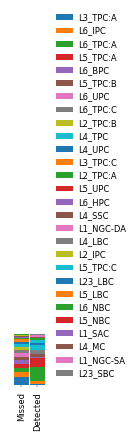

In [12]:
# format dataset to plot
df = plot_data["mtype"][plot_data["bias"] == "Missed"]
df_ratio_missed = df.value_counts(normalize=True)
df_ratio_missed = df_ratio_missed.to_frame()
df_ratio_missed.columns = ["Missed"]

df = plot_data["mtype"][plot_data["bias"] == "Detected"]
df_ratio_detected = df.value_counts(normalize=True)
df_ratio_detected = df_ratio_detected.to_frame()
df_ratio_detected.columns = ["Detected"]

# concat for plot
plot_data3 = pd.concat([df_ratio_missed, df_ratio_detected], axis=1)

# reorder mtype
# plot_data3 = plot_data3.loc[["6", "5", "4", "2/3", "1"]]

fig, axis = plt.subplots(1, 1, figsize=(0.5, 0.7))
ax = (plot_data3).T.plot.bar(
    ax=axis,
    stacked=True,
    # color=colors,
    width=0.9,
    edgecolor="none",
    linewidth=0.2,
)

# set axis legend
ax.spines[["left", "right", "top", "bottom"]].set_visible(False)
y_axis = ax.axes.get_yaxis()
y_axis.set_visible(False)
ax.set_ylabel("Sorting biases (ratio)", fontsize=9)

# hs, ls = ax.get_legend_handles_labels()
# hss = [hs[4], hs[3], hs[2], hs[1], hs[0]]
# lss = [ls[4], ls[3], ls[2], ls[1], ls[0]]

ax.legend(
    plot_data3.index,
    ncol=1,
    loc="lower left",
    bbox_to_anchor=(1, 0),
    frameon=False,
    handletextpad=0.6,
    # handles=hss,
    # labels=lss,
)

# save figures
plt.savefig(
    "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/spikebias/figures/3_bias/svg/portrait_mtype_dark_units_ks3.svg",
    **savefig_cfg,
)

#### plot 2

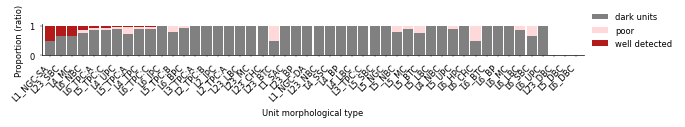

In [358]:
NOT_FOUND_MTYPE = ["L23_DBC", "L5_DBC", "L6_DBC"]

# calculate ratio of sorting quality by mtype
ctab = pd.crosstab(df["mtype"], df["quality"])
sum_ctab = pd.crosstab(df["mtype"], df["quality"]).sum(axis=1)
ctab_ratio = ctab.apply(lambda x: x / sum_ctab)

# add mtypes found in evoked neuropixels simulation but not in spontaneous marques

absent = pd.DataFrame(
    data=np.nan * np.ones((len(NOT_FOUND_MTYPE), ctab_ratio.shape[1]))
)
absent.index = NOT_FOUND_MTYPE
absent.columns = ctab_ratio.columns
ctab_ratio = pd.concat([ctab_ratio, absent])

# sort
ctab_ratio = ctab_ratio.sort_values(by=["well detected"], ascending=False)

# plot
fig, ax = plt.subplots(1, figsize=(7, 0.4))
ax = ctab_ratio.plot.bar(ax=ax, stacked=True, color=colors, width=0.9, linestyle="None")

# add legend
ax.set_xticklabels(ctab_ratio.index, rotation=45, ha="right")
ax.set_ylabel("Proportion (ratio)")
ax.set_xlabel("Unit morphological type")
ax.legend(frameon=False, loc="lower left", bbox_to_anchor=(1, 0))


# save figures
plt.savefig(
    "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/spikebias/figures/3_bias/svg/portrait_mtype_dark_units_marques_ks3_plot2.svg",
    **savefig_cfg,
)

In [349]:
ctab_ratio.index

Index(['L1_NGC-SA', 'L23_SBC', 'L4_MC', 'L6_NBC', 'L6_TPC:A', 'L5_TPC:C',
       'L4_UPC', 'L5_TPC:A', 'L4_TPC', 'L6_TPC:C', 'L6_IPC', 'L5_TPC:B',
       'L6_BPC', 'L3_TPC:A', 'L2_TPC:B', 'L2_IPC', 'L2_TPC:A', 'L23_LBC',
       'L23_MC', 'L23_CHC', 'L23_BTC', 'L1_SAC', 'L23_BP', 'L1_NGC-DA',
       'L23_NBC', 'L4_SSC', 'L4_BP', 'L4_LBC', 'L3_TPC:C', 'L5_SBC', 'L5_NGC',
       'L5_NBC', 'L5_MC', 'L5_BTC', 'L5_LBC', 'L4_NBC', 'L5_UPC', 'L6_HPC',
       'L6_CHC', 'L6_BTC', 'L6_BP', 'L6_MC', 'L6_LBC', 'L6_SBC', 'L6_UPC',
       'L23_DBC', 'L5_DBC', 'L6_DBC'],
      dtype='object')

In [351]:
len(
    [
        "L1_NGC-SA",
        "L23_SBC",
        "L4_MC",
        "L6_NBC",
        "L6_TPC:A",
        "L5_TPC:C",
        "L4_UPC",
        "L5_TPC:A",
        "L4_TPC",
        "L6_TPC:C",
        "L6_IPC",
        "L5_TPC:B",
        "L6_BPC",
        "L3_TPC:A",
        "L2_TPC:B",
        "L2_IPC",
        "L2_TPC:A",
        "L23_LBC",
        "L23_MC",
        "L23_CHC",
        "L23_BTC",
        "L1_SAC",
        "L23_BP",
        "L1_NGC-DA",
        "L23_NBC",
        "L4_SSC",
        "L4_BP",
        "L4_LBC",
        "L3_TPC:C",
        "L5_SBC",
        "L5_NGC",
        "L5_NBC",
        "L5_MC",
        "L5_BTC",
        "L5_LBC",
        "L4_NBC",
        "L5_UPC",
        "L6_HPC",
        "L6_CHC",
        "L6_BTC",
        "L6_BP",
        "L6_MC",
        "L6_LBC",
        "L6_SBC",
        "L6_UPC",
        "L23_DBC",
        "L5_DBC",
        "L6_DBC",
    ]
)

48